# 1a

In [80]:
import numpy as np
import matplotlib.pyplot as plt


These are some helper functions that will be used at various points throughout the assignment.

In [81]:
def generateRandomPoint(width, height):
    '''Helper function to (uniformly) generate a random point within a square of a given width and height.'''
    return (np.random.uniform(0, width), np.random.uniform(0, height))

def generateRandomPointInCircle(R):
    '''Generate a random point within a circle of radius R centered at the origin.'''
    theta = np.random.uniform(0, 2 * np.pi)
    r = R * np.sqrt(np.random.uniform(0, 1))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return (x, y)

def distance(x1, y1, x2, y2):
        '''Gets the distance between (x1, y1) and (x2, y2).'''
        return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def distToLine(a, b, x0, y0):
    '''Calculates the distance from (x0, y0) to the line y = a x + b'''
    return np.abs(a*x0 + b - y0)/np.sqrt(1 + a**2)

def line_circleIntersection(a, b, x_C, y_C, R):
    '''Takes in the parameters defining a line and a circle and finds the point of intersection closest to the origin. Assumes there is a point of intersection! Also assumes the line passes through the origin.
    
    Returns the point of intersection as a tuple (x,y)
    '''
    # Define coefficients
    A = a**2 + 1
    B = - 2*x_C - 2*a*y_C
    C = x_C**2 + y_C**2 - R**2
    # Calculate points of intersection
    x1, y1 = (-B + np.sqrt(B^2-4*A*C))/(2*A), a*(-B + np.sqrt(B^2-4*A*C))/(2*A)
    x2, y2 = (-B - np.sqrt(B^2-4*A*C))/(2*A), a*(-B - np.sqrt(B^2-4*A*C))/(2*A)
    # Find the one closest to the origin and return it
    if distance(x1, y1, 0, 0) < distance(x2, y2, 0, 0):
        return (x1, y1)
    else:
        return (x2, y2)



Let's make a tree class to represent the trees in the forest.

In [82]:
class Tree:
    def setOriginDistance(self, d):
        '''
        Sets the distance of self to the origin to d
        
        NB: This doesn't change the position of the Tree!
        '''
        self.origin_dist = d

    '''A Tree in the Sherwood Forest.'''
    def setDiameter(self, D):
        '''Sets diameter of self to D.'''
        self.diameter = D
        
    def setPosition(self, x, y):
        '''Sets position of self to (x,y).'''
        self.x_pos = x
        self.y_pos = y

    def setArgument(self, theta):
        '''This sets the angle between self and the x-axis to theta. Equivalent to the argument of a complex number.'''
        self.arg = theta

    def __lt__(self, other):
        '''For sorting purposes. Returns True if self is closer to the origin than other, False otherwise.'''
        return self.origin_dist < other.origin_dist


            

If the forest is big enough, it is impossible to tell whether you are at the center or not just by looking around. This means we can assume that Robin Hood is at the center, so we simply place him at the origin and generate a circular forest around him, making sure not to place trees at the origin.  

In fact, for the sake of realism, let's give Robin some space and say that he is at least one meter from any trees.

In [83]:
# We use the values from Ryden and R=100 as our default values
def generateForest(sigma=0.005, R=100, D=2):
    '''
    Generates a 2d forest of Trees placed randomly in a circle centered on the origin. Also

    Parameters:
    sigma (positive float): The density of the trees pr. unit area
    R (positive float): The radius of the circle within which the forest will be generated
    D (positive float): The diameter of the trees in the forest
    
    Returns a list of Trees.
    '''
    # Calculate area and number of trees to place
    area = np.pi*R**2
    n_Trees = int(sigma*area)

    forest = []

    while len(forest) < n_Trees:
        # Generate a random point in the circle
        x, y = generateRandomPointInCircle(R)

        new_tree = Tree()
        new_tree.setDiameter(D)
        new_tree.setPosition(x, y)
        new_tree.setOriginDistance(distance(x, y, 0, 0))
        new_tree.setArgument(np.arctan2(y, x))

        # Check if the new Tree touches any existing trees before appending it to the forest
        # We also make sure not to place any trees at the origin
        # all() returns True iff all elements of a list are True
        if all(distance(x, y, tree.x_pos, tree.y_pos) >= D for tree in forest) and new_tree.origin_dist >= 1:
            forest.append(new_tree)

    return forest
        



It would be nice to have a plot of the forest, so let's add that.

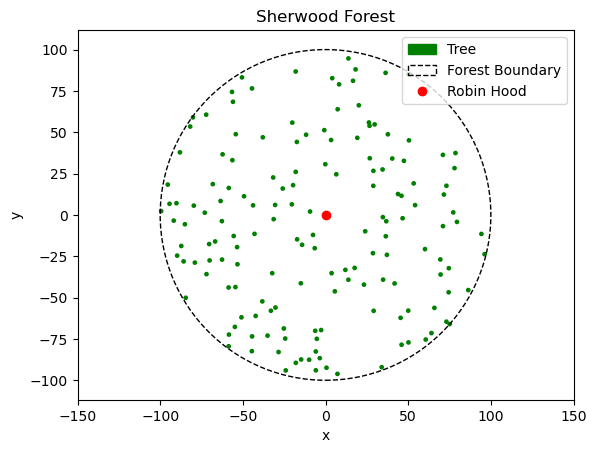

In [87]:
def plotForest(sigma=0.005, R=100, D=2):
    '''
    Plots a forest of Trees.
    
    Takes in the same parameters as generateForest().
    '''
    forest = generateForest(sigma, R, D)
    # Used to avoid setting a label for each Tree
    label_has_been_set = False

    # This adds each tree to the forest
    for tree in forest:
        if label_has_been_set:
            circle = plt.Circle((tree.x_pos, tree.y_pos), tree.diameter/2, color='green', fill=True)
        else:
            circle = plt.Circle((tree.x_pos, tree.y_pos), tree.diameter/2, color='green', fill=True, label='Tree')
            label_has_been_set = True
        plt.gca().add_artist(circle)

    # Draws boundary around the forest    
    circle = plt.Circle((0, 0), R, color='black', fill=False, linestyle='dashed', label='Forest Boundary')
    plt.gca().add_artist(circle)

    # Draws a dot at the origin
    plt.plot(0, 0, 'ro', label='Robin Hood')

    # Makes sure the axes are scaled the same, so the plot doesn't become 'squished'
    plt.axis('equal')
    # Sets appropriate x and y limits to make the whole forest visible
    plt.xlim(-1.5*R, 1.5*R)
    plt.ylim(-1.5*R, 1.5*R)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Sherwood Forest')
    plt.legend(loc='upper right')
    plt.show()

plotForest(0.005, 100, 2)

Now we need to implement the shooting of the arrow and check when it hits a tree. Since Robin Hood is shooting the arrow from the origin, we can represent its path with a line $l$ given by $y = a x$. We can use the formula for the distance from a point to a line to get the distance from the center of a tree at $C=(x_C, y_C)$ to the line:  

$\text{dist}(C, l) = \dfrac{|a x_C - y_C|}{\sqrt{a^2 + 1}}$  

Obviously, if this distance is less than the radius of the tree, the arrow will hit it. If we do hit a tree, we also need to find the point of intersection. The equation of the circle representing the tree in terms of its radius $R$ is:

$(x - x_C)^2 + (y - y_C)^2 = R^2$

Combining this with the equation for $l$ at the point of intersection $(x_0, y_0)$ yields:

$(x_0 - x_C)^2 + (a x_0 - y_C)^2 = R^2$

Which is a quadratic equation $A x^2 + B x + C = 0$ with the following coefficients:  

$A = a^2 + 1$  
$B = - 2 x_C - 2a y_C$  
$C = x_C^2 + y_C^2 - R^2$  

So the points of intersection are:
$\left(\dfrac{-B \pm \sqrt{B^2 - 4 A C}}{2A}, \, a\left[ \dfrac{-B \pm \sqrt{B^2 - 4 A C}}{2A} \right] \right)$

We can simply find both points of intersection and choose the one closest to the origin.

We'll run this check on all trees, starting with the ones closest to the origin and moving outward from there until we detect a collision. If we need to, we can always find more ways to optimize this later.  

Also, as the arrow can only travel in one direction along the line, we'll need to make sure we only check one ''side'' of the line. Otherwise we might detect collisions with the part of the line that is behind the arrows path. This can be done by comparing the angle the path of the arrow makes with the origin with the argument of the trees.

In [85]:
def shootArrow(forest):
    '''
    Shoots an arrow in a random direction from the origin and returns the point where it hits a tree.

    Takes in a forest from the generateForest() function as a parameter.

    Returns the point of intersection with the first tree the arrow hits if there is a collision, False otherwise.
    '''
    # We'll generate random direction for the arrow using polar coordinates
    theta = np.random.uniform(0, 2*np.pi)
    a = np.tan(theta)
    b = 0 # Since we're shooting from the origin

    for tree in forest:
        x0, y0 = tree.x_pos, tree.y_pos
        # Check if the tree is in the direction in which the arrow was fired
        if 0 <= theta < np.pi:
            if 0 <= tree.arg < np.pi:
                pass # Keep going
        elif np.pi <= tree.arg < 2*np.pi:
            pass # Keep going
        else:
            continue # If the three is on the wrong side, we go to the next iteration of the loop without checking if the line intersects the tree

        # If the line intersects the tree
        if distToLine(a, b, x0, y0) <= tree.diameter / 2:
            return line_circleIntersection(a, b, tree.x_pos, tree.y_pos, tree.diameter / 2)
    
    return False
            

